In [1]:
"""
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
"""

"\n!apt-get --purge remove cuda nvidia* libnvidia-*\n!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge\n!apt-get remove cuda-*\n!apt autoremove\n!apt-get update\n!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb\n!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb\n!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub\n!apt-get update\n!apt-get install cuda-9.2\n!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git\n%load_ext nvcc_plugin\n"

In [2]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist
!pip install tensorboardX
!pip install acsconv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=cb70b40ba7469819f253e4916dd8fab5866be82aec0afcc32c4a16ede9590d03
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import os
import argparse
from tqdm import trange
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
# from tensorboardX import SummaryWriter
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

from sklearn.metrics import roc_auc_score
from acsconv.converters import Conv3dConverter

import os
import time
from PIL import Image
import numpy as np
import random

random_seed = 41
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [4]:
# Load vesselMNIST3d
data_flag = 'nodulemnist3d'
download = True
as_rgb = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [5]:
class Transform3D:

    def __init__(self, mul=None):
        self.mul = mul

    def __call__(self, voxel):
   
        if self.mul == '0.5':
            voxel = voxel * 0.5

        elif self.mul == 'random':
            voxel = voxel * np.random.uniform()
        
        return voxel.astype(np.float32)

In [6]:
random_seed = 41
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE = 64
imratio = 0.1  # for demo
total_epochs = 120
#decay_epochs = [50, 75]
shape_transform = True


# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
# Define transformations
transform_train = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
"""

#Transformations
train_transform = Transform3D(mul='random') if shape_transform else Transform3D()
eval_transform = Transform3D(mul='0.5') if shape_transform else Transform3D()

#Define Datasets
train_dataset = DataClass(split='train', transform=train_transform, download=download, as_rgb=as_rgb)
train_dataset_at_eval = DataClass(split='train', transform=eval_transform, download=download, as_rgb=as_rgb)
val_dataset = DataClass(split='val', transform=eval_transform, download=download, as_rgb=as_rgb)
test_dataset = DataClass(split='test', transform=eval_transform, download=download, as_rgb=as_rgb)

# Load data
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset_at_eval, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Instantiate the ResNet-18 3D model and set it to training mode
from libauc.models import resnet18 as ResNet18
model = ResNet18(pretrained=False)
model = model.cuda()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
model = Conv3dConverter(model)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2)
)

# Define loss function and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, loss_fn=loss_fn, momentum=0.8, margin=1.0, epoch_decay=0.05, lr=0.1, weight_decay=1e-7)

# Set early stopping parameters
early_stop_epochs = 10 # Stop if validation AUC does not improve for 10 epochs
best_val_auc = 0
best_test_auc = 0
epochs_since_last_improvement = 0

# Training loop
print('Start Training')
print('-'*40)

train_log = []
test_log = []
val_log = []
for epoch in range(total_epochs):
    train_loss = []
    model = model.cuda()
    model.train()
    for data, targets in train_loader:
        data, targets = data.cuda(), targets.cuda()
        y_pred = model(data)
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Evaluation on train & test sets
    model.eval()
    train_pred_list = []
    train_true_list = []
    for train_data, train_targets in train_loader_at_eval:
        train_data = train_data.cuda()
        train_pred = model(train_data)
        train_pred_list.append(train_pred.cpu().detach().numpy())
        train_true_list.append(train_targets.numpy())
    train_true = np.concatenate(train_true_list)
    train_pred = np.concatenate(train_pred_list)
    train_auc = auc_roc_score(train_true, train_pred)
    train_loss = np.mean(train_loss)

    val_pred_list = []
    val_true_list = []
    for val_data, val_targets in val_loader:
         val_data = val_data.cuda()
         val_pred = model(val_data)
         val_pred_list.append(val_pred.cpu().detach().numpy())
         val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)
    val_auc =  auc_roc_score(val_true, val_pred)

    test_pred_list = []
    test_true_list = []
    for test_data, test_targets in test_loader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
    test_true = np.concatenate(test_true_list)
    test_pred = np.concatenate(test_pred_list)
    test_auc =  auc_roc_score(test_true, test_pred) 
    model.train()

    # print results
    print("epoch: %s, train_loss: %.4f, train_auc: %.4f, val_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.lr ))    
    train_log.append(train_auc[0]) 
    test_log.append(test_auc[0])
    val_log.append(val_auc[0])

    # Check for early stopping
    if val_auc[0] > best_val_auc:
        best_model = model
        best_val_auc = val_auc[0] 
        best_test_auc = test_auc[0] #Test AUC corresponding to best Val AUC
        epochs_since_last_improvement = 0      
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= early_stop_epochs:
            print(f"No improvement in validation AUC for {early_stop_epochs} epochs. Training stopped early.")
            break


100%|██████████| 29299364/29299364 [00:54<00:00, 542377.38it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Start Training
----------------------------------------
epoch: 0, train_loss: 15.3355, train_auc: 0.5536, val_auc: 0.5815, test_auc: 0.5655, lr: 0.1000
epoch: 1, train_loss: 0.1891, train_auc: 0.5994, val_auc: 0.6529, test_auc: 0.5981, lr: 0.1000
epoch: 2, train_loss: 0.1887, train_auc: 0.6157, val_auc: 0.6694, test_auc: 0.6253, lr: 0.1000
epoch: 3, train_loss: 0.1769, train_auc: 0.5933, val_auc: 0.6434, test_auc: 0.6007, lr: 0.1000
epoch: 4, train_loss: 0.1766, train_auc: 0.6498, val_auc: 0.7019, test_auc: 0.6614, lr: 0.1000
epoch: 5, train_loss: 0.1770, train_auc: 0.6163, val_auc: 0.6678, test_auc: 0.6173, lr: 0.1000
epoch: 6, train_loss: 0.1771, train_auc: 0.6406, val_auc: 0.6901, test_auc: 0.6616, lr: 0.1000
epoch: 7, train_loss: 0.1701, train_auc: 0.5965, val_auc: 0.6297, te

In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License: CC BY 4.0
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 310
    Root location:

In [8]:
print(best_test_auc)

0.900660569105691


In [9]:
state = {
    'net': best_model.state_dict(),
}

output_root = os.path.join('./output', 'noduleMNIST3D', time.strftime("%y%m%d_%H%M%S"))
if not os.path.exists(output_root):
    os.makedirs(output_root)

path = os.path.join(output_root, 'best_model.pth')
torch.save(state, path)

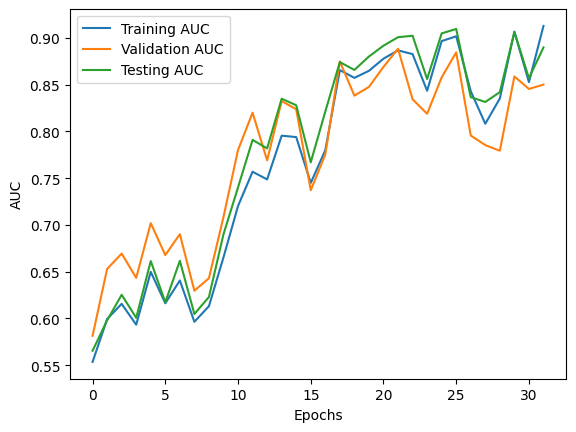

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(val_log, label='Validation AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [11]:
print("Final Validation AUC:", best_val_auc)
print("Final Test AUC:", best_test_auc)


Final Validation AUC: 0.8883081687959737
Final Test AUC: 0.900660569105691
